<img src = 'jorge-franganillo-34zq7tzqRSw-unsplash.jpg'>

# Importing Librarires

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , Embedding , Flatten , LSTM , GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from sklearn.metrics import confusion_matrix , roc_curve , roc_auc_score , classification_report , f1_score ,  accuracy_score , precision_score , recall_score
from collections import Counter

plt.rcParams["figure.figsize"] = (12,8)
import warnings
warnings.filterwarnings(action="ignore")

# Importing Dataset

In [2]:
df = pd.read_csv("news_dataset.csv")
df.head()

,label,text
0,REAL,Payal has accused filmmaker Anurag Kashyap of ...
1,FAKE,A four-minute-long video of a woman criticisin...
2,FAKE,"Republic Poll, a fake Twitter account imitatin..."
3,REAL,"Delhi teen finds place on UN green list, turns..."
4,REAL,Delhi: A high-level meeting underway at reside...


# Converting Dependent variable to numeric

In [3]:
df["label"] = df["label"].map({"FAKE"  : 0, "REAL" : 1})

# Checking if there are null values in the data set or not

In [4]:
df.isnull().sum()

label    0
text     8
dtype: int64

In [5]:
df.dropna(inplace = True)

# The proportion of dependent variable

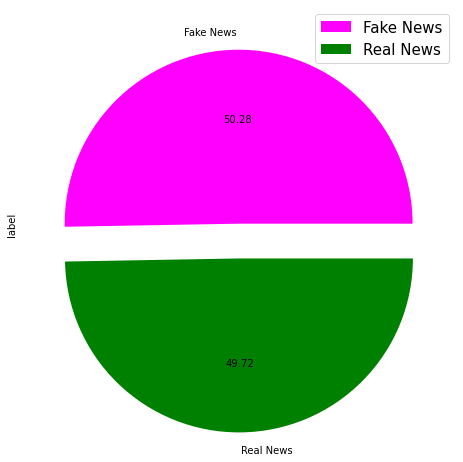

In [6]:
df["label"].value_counts().plot(kind = "pie" , autopct = "%.2f" , explode = [0.0 , 0.2] , colors = ["magenta" , "green"] , labels = ["Fake News" , "Real News"])
plt.legend(loc = "best" , fontsize = 15)
plt.show()

# Checking if there are duplicate values in the dataset or not

In [7]:
print("There are {} duplicate values in the dateset".format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)
print("There are {} duplicate values in the dataset".format(df.duplicated().sum()))

There are 1492 duplicate values in the dateset
There are 0 duplicate values in the dataset


# Splitting Dataset to X and y

In [8]:
X = df["text"]
y = df["label"]

# Splitting Dataset to train and test set

In [9]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42)

# Automate Roc_curve , Confussion Matrix , Metrics

In [10]:
def metrics_func(y_pred_train , y_pred_test) : 
    roc_train = roc_auc_score(y_train , y_pred_train)
    gini_train = (2*roc_train)-1
    f1_train = f1_score(y_train , y_pred_train)
    acuracy_train = accuracy_score(y_train , y_pred_train)
    prec_train = precision_score(y_train , y_pred_train)
    recall_train = recall_score(y_train , y_pred_train)
    
    roc_test = roc_auc_score(y_test , y_pred_test)
    gini_test = (2*roc_test)-1
    f1_test = f1_score(y_test , y_pred_test)
    acuracy_test = accuracy_score(y_test , y_pred_test)
    prec_test = precision_score(y_test , y_pred_test)
    recall_test = recall_score(y_test , y_pred_test)
    
    print("<<< Metrics for Train set >>>")
    print("The Roc auc score is {:.2%}".format(roc_train))
    print("The Gini score is {:.2%}".format(gini_train))
    print("The F1 score is {:.2%}".format(f1_train))
    print("The Accuracy score is {:.2%}".format(acuracy_train))
    print("The Precission score is {:.2%}".format(prec_train))
    print("The Recall score is {:.2%}".format(recall_train))
    print()
    print("<<< Metrics for Test set >>>")
    print("The Roc auc score is {:.2%}".format(roc_test))
    print("The Gini score is {:.2%}".format(gini_test))
    print("The F1 score is {:.2%}".format(f1_test))
    print("The Accuracy score is {:.2%}".format(acuracy_test))
    print("The Precission score is {:.2%}".format(prec_test))
    print("The Recall score is {:.2%}".format(recall_test))

In [11]:
def confussion_func(model_name , y_pred_train , y_pred_test) : 
    cm_train = confusion_matrix(y_train , y_pred_train)
    cm_test = confusion_matrix(y_test , y_pred_test)
    
    sns.set(font_scale = 1.5 , palette = "bright")
    plt.figure(figsize = (30,18))
    plt.subplot(2,3,1)
    sns.heatmap(data = cm_train , cmap = plt.cm.Blues , cbar = False , fmt=".5g" , annot = True)
    plt.title("The Confussion Matrix for Train set" , fontsize = 20)
    plt.ylabel("The Ground Truth" , fontsize = 18)
    plt.xlabel("The Predictions" , fontsize = 18)
    plt.subplot(2,3,2)
    upper_stack = cm_train[0]/np.sum(cm_train , axis = 1)[0]
    lower_stack = cm_train[1]/np.sum(cm_train , axis = 1)[1]
    final_stack = np.vstack([upper_stack , lower_stack])
    sns.heatmap(data = final_stack , cmap = plt.cm.Blues , cbar = False , fmt = ".0%" , annot = True)
    plt.title("The Confussion Matrix for Train set with Recall Ratio" , fontsize = 20)
    plt.ylabel("The Ground Truth" , fontsize = 18)
    plt.xlabel("The Predictions" , fontsize = 18)
    plt.subplot(2,3,3)
    left_stack = cm_train[:,0]/np.sum(cm_train , axis = 0)[0]
    right_stack = cm_train[:,1]/np.sum(cm_train , axis = 0)[1]
    result = np.stack([left_stack , right_stack])
    sns.heatmap(data = result , cmap = plt.cm.Blues , cbar = False , fmt = ".0%" , annot = True)
    plt.title("The Confussion Matrix for Train set with Precission Ratio" , fontsize = 20)
    plt.ylabel("The Ground Truth" , fontsize = 18)
    plt.xlabel("The Predictions" , fontsize = 18)
    
    plt.subplot(2,3,4)
    sns.heatmap(data = cm_test , cmap = plt.cm.Blues , cbar = False , fmt=".5g" , annot = True)
    plt.title("The Confussion Matrix for test set" , fontsize = 20)
    plt.ylabel("The Ground Truth" , fontsize = 18)
    plt.xlabel("The Predictions" , fontsize = 18)
    plt.subplot(2,3,5)
    upper_stack = cm_test[0]/np.sum(cm_test , axis = 1)[0]
    lower_stack = cm_test[1]/np.sum(cm_test , axis = 1)[1]
    final_stack = np.vstack([upper_stack , lower_stack])
    sns.heatmap(data = final_stack , cmap = plt.cm.Blues , cbar = False , fmt = ".0%" , annot = True)
    plt.title("The Confussion Matrix for Test set with Recall Ratio" , fontsize = 20)
    plt.ylabel("The Ground Truth" , fontsize = 18)
    plt.xlabel("The Predictions" , fontsize = 18)
    plt.subplot(2,3,6)
    left_stack = cm_train[:,0]/np.sum(cm_train , axis = 0)[0]
    right_stack = cm_train[:,1]/np.sum(cm_train , axis = 0)[1]
    result = np.stack([left_stack , right_stack])
    sns.heatmap(data = result , cmap = plt.cm.Blues , cbar = False , fmt = ".0%" , annot = True)
    plt.title("The Confussion Matrix for Test set with Precission Ratio" , fontsize = 20)
    plt.ylabel("The Ground Truth" , fontsize = 18)
    plt.xlabel("The Predictions" , fontsize = 18)

In [12]:
def roc_curve_func(model_name , y_pred_train , y_pred_test , y_pred_prob_train , y_pred_proba_test) : 
    
    roc_train = roc_auc_score(y_true = y_train , y_score = y_pred_train)
    roc_test = roc_auc_score(y_true = y_test , y_score=y_pred_test)
    
    fpr,  tpr , _ = roc_curve(y_true = y_train , y_score = y_pred_prob_train)
    plt.plot(fpr , tpr , label = f"Our Model with {np.round(roc_train)}" , c = "magenta")
    plt.plot([0,1] , [0,1] , label = "Random Model" , c = "red")
    plt.title("The Roc Curve for Train set" , fontsize = 16)
    plt.xlabel("The True Positive Rate" , fontsize = 16)
    plt.ylabel("The False Positve Rate" , fontsize = 16)
    plt.show()
    
    fpr , tpr , _ = roc_curve(y_true = y_test , y_score = y_pred_proba_test)
    plt.plot(fpr, tpr , label = f"Our model with {np.round(roc_test)}" , c = "magenta")
    plt.plot([0,1] , [0,1] , label = "Random Model" , c = "red")
    plt.title("The Roc Curve for Test set" , fontsize = 16)
    plt.ylabel("The True Positive Rate" , fontsize = 16)
    plt.xlabel("The False Positive Rate" , fontsize = 16)
    plt.show()

# Creating Vocablary

In [13]:
def count(text) : 
    count = Counter()
    for x in text : 
        for i in x.split() : 
            count[i] += 1
    return count      

In [14]:
Counter = count(text = df["text"])
vocab_size = len(Counter)
avg_sequence_size = round(np.mean([len(x.split()) for x in X_train]))

# Creating Tokenizer

In [15]:
token = Tokenizer(num_words=vocab_size , oov_token="OOV")
token.fit_on_texts(X_train)

# Creating Sequences for both Train and Test set

In [16]:
train_seq = token.texts_to_sequences(X_train)
test_seq = token.texts_to_sequences(X_test)

# Applying pad_sequence function to make length of senteces equal

In [17]:
padding_train = pad_sequences(sequences=train_seq , maxlen=avg_sequence_size , padding="post" , truncating="post")
padding_test = pad_sequences(sequences=test_seq , maxlen=avg_sequence_size , padding="post" , truncating="post")

# Creating Callbacks

In [18]:
def callbacks(model_path , verbosity = 1 , monitoring = "val_loss") : 
    early = EarlyStopping(monitor= monitoring , patience=5 ,verbose=verbosity , restore_best_weights=True)
    check = ModelCheckpoint(filepath=model_path , monitor=monitoring , verbose=verbosity , save_best_only=True)
    
    callbacks = [early , check]
    
    return callbacks

# Creating Deep Learning model

In [19]:
model_dl = Sequential(layers = [
    Embedding(input_dim=vocab_size , output_dim=128 , input_length=avg_sequence_size),
    Flatten(),
    Dense(units = 128 , activation="relu"),
    Dropout(rate = 0.2 , seed = 42),
    Dense(units = 128 , activation="relu"),
    Dropout(rate = 0.2 , seed = 42),
    Dense(units = 256 , activation="relu"),
    Dropout(rate = 0.2 , seed = 42),
    Dense(units = 256 , activation="relu"),
    Dropout(rate = 0.2 , seed = 42),
    Dense(units = 528 , activation="relu"),
    Dropout(rate = 0.2 , seed = 42),
    Dense(units = 528 , activation="relu"),
    Dropout(rate = 0.2 , seed = 42),
    Dense(units = 1 , activation="sigmoid")
] , name = "NLP")

model_dl.compile(optimizer=Adam() , loss=BinaryCrossentropy() , metrics=["accuracy"])

In [20]:
model_dl.fit(x = padding_train , y = y_train , validation_data=(padding_test , y_test) , batch_size = 5 , epochs = 100 , callbacks=callbacks(model_path=f"{model_dl.name}.h5"))

Epoch 1/100
357/357 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9383
Epoch 1: val_loss improved from inf to 0.81552, saving model to NLP.h5
357/357 [==============================] - 81s 222ms/step - loss: 0.1717 - accuracy: 0.9383 - val_loss: 0.8155 - val_accuracy: 0.9372
Epoch 2/100
357/357 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9899
Epoch 2: val_loss improved from 0.81552 to 0.01110, saving model to NLP.h5
357/357 [==============================] - 79s 220ms/step - loss: 0.0572 - accuracy: 0.9899 - val_loss: 0.0111 - val_accuracy: 0.9933
Epoch 3/100
357/357 [==============================] - ETA: 0s - loss: 1.1300e-05 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.01110 to 0.01003, saving model to NLP.h5
357/357 [==============================] - 79s 221ms/step - loss: 1.1300e-05 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 0.9955
Epoch 4/100
357/357 [==============================] - ETA: 0s - loss: 1.4862e

# Evaluate the performance of model

In [21]:
train_score = model_dl.evaluate(padding_train , y_train)
test_score = model_dl.evaluate(padding_test , y_test)

14/14 [==============================] - 0s 15ms/step - loss: 0.0092 - accuracy: 0.9955


# The metrics for Deep Learning model

In [22]:
y_pred_train = tf.math.round(tf.squeeze(model_dl.predict(padding_train)))
y_pred_test = tf.math.round(tf.squeeze(model_dl.predict(padding_test)))
metrics_func(y_pred_train , y_pred_test)

14/14 [==============================] - 0s 15ms/step
<<< Metrics for Train set >>>
The Roc auc score is 100.00%
The Gini score is 100.00%
The F1 score is 100.00%
The Accuracy score is 100.00%
The Precission score is 100.00%
The Recall score is 100.00%

<<< Metrics for Test set >>>
The Roc auc score is 99.21%
The Gini score is 98.41%
The F1 score is 98.68%
The Accuracy score is 99.55%
The Precission score is 98.68%
The Recall score is 98.68%


# Confussion Matrix for Deep Learning model

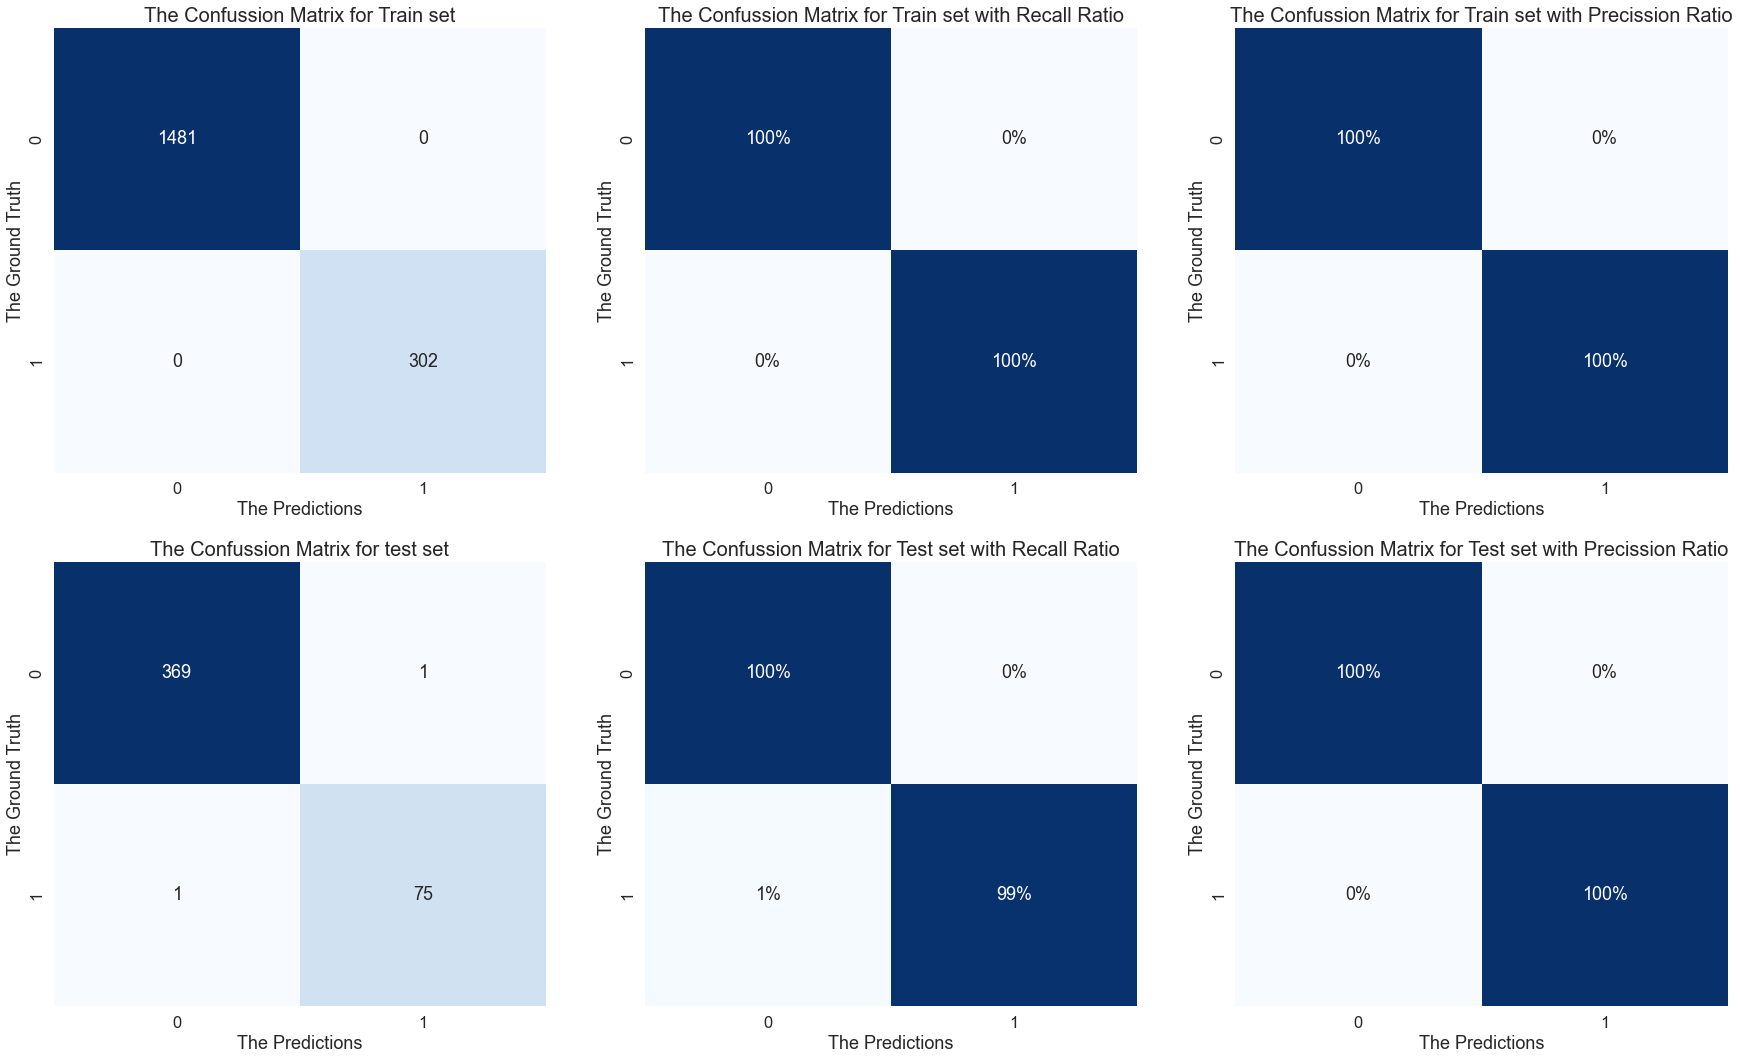

In [23]:
confussion_func(model_dl , y_pred_train , y_pred_test)

# Roc Curve for Deep Learning model

14/14 [==============================] - 0s 16ms/step


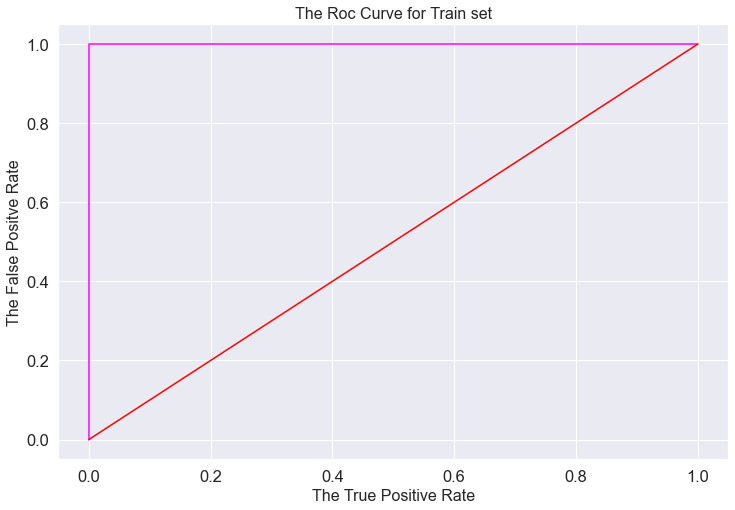

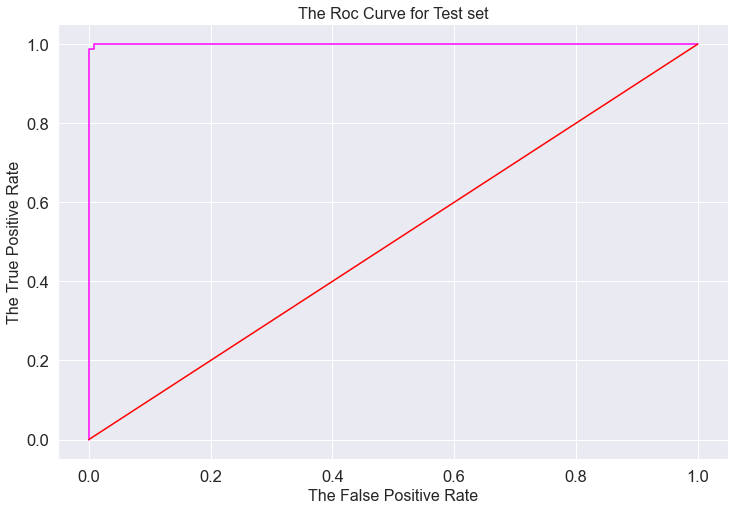

In [ ]:
y_pred_proba_train = tf.squeeze(model_dl.predict(padding_train))
y_pred_proba_test = tf.squeeze(model_dl.predict(padding_test))
roc_curve_func(model_name= model_dl ,y_pred_train=y_pred_train , y_pred_test=y_pred_test , y_pred_prob_train=y_pred_proba_train , y_pred_proba_test=y_pred_proba_test)

# Predictions

In [27]:
fake = ["Watch episode-5 Of Fact Vs Fiction where Suyash Barve & Jency Jacob discuss the fake news stories in the last one week and how you can spot them on social media.In this Video we cover the following stories:Modi Vs Gandhi: Twitter Analytics Reveal Fake Followers Plague Both Handles Twitter Fact Checks Kiran Bedi’s Fake Video Of PM Modi’s Mother Celebrating Diwali The Story Behind This Viral Image: Photo Fact FileReal Vs Reel: FactChecking Mersal’s Claims On GST, Demonetisation"]

tf.math.round(tf.squeeze(model_dl.predict(pad_sequences(sequences=token.texts_to_sequences(fake) , maxlen=avg_sequence_size,
                                                      padding="post" , truncating="post"))))

1/1 [==============================] - 0s 60ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [28]:
real = ["'Kareena Kapoor Khan, who is all set to ring in her 40birthday tomorrow on September 21, took to her Instagram handle to share a monochrome selfie, smiling as she looks back to the milestones she achieved before entering her 40th year.Check out her post here:She wrote, As I enter my 40th year... I want to sit back, reflect, love, laugh, forgive, forget and most importantly pray and thank the strongest force up there for giving me the strength and thank my experiences and decisions for making me the woman I am... Some right, some wrong, some great, some not so... but still, hey BIG 40 make it BIG.The star icon is an epitome of expressions and has gifted her fans a filmography of nearly 60 films. She is currently expecting her second child with Saif Ali Khan . The couple had made an official statement last month saying, “We are very pleased to announce that we are expecting an addition to our family !!Thank you to all our well wishers for all their love and support.”On the work front, Kareena will next be seen in Karan Johar ’s period drama ‘Takht’ and Aamir Khan starrer, ‘Laal Singh Chaddha’.'"]
tf.math.round(tf.squeeze(model_dl.predict(pad_sequences(sequences=token.texts_to_sequences(real) , maxlen=avg_sequence_size,
                                                      padding="post" , truncating="post"))))

1/1 [==============================] - 0s 27ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=1.0>